In [11]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.manifold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

In [16]:
# import data
df = pd.read_csv('../data/Iris.csv')
data = df[['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']]
labels = df['Species'].apply(lambda x: x.split('-')[-1])

# Standardize the data (mean=0, variance=1)
scaler = StandardScaler()
data_scld = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(data_scld, labels, test_size=0.2, random_state=42)
print(f'training data: {y_train.shape[0]}')
print(f'testing data: {y_test.shape[0]}')

training data: 120
testing data: 30


cumulative explained variance: [0.71309075 0.95599722]


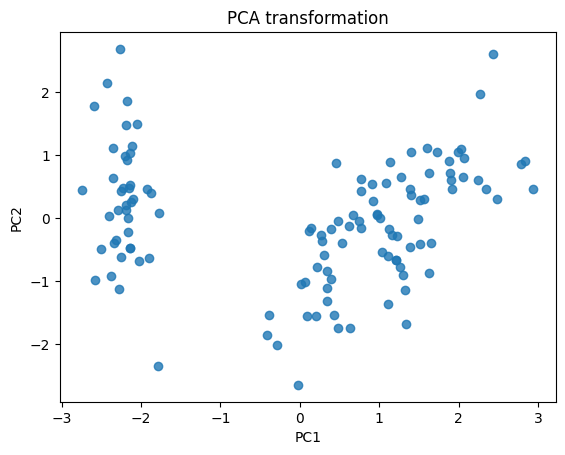

In [10]:
# train PCA on the data
def train_pca(data, num_components=2):
    # Initialize PCA
    pca_model = PCA(n_components=num_components)

    # fit the PCA object to the data then transform the input data
    data_pca = pca_model.fit_transform(data)

    # Create a DataFrame for the transformed data
    df_pca = pd.DataFrame(
        data_pca, columns=[f"PC{i + 1}" for i in range(num_components)]
    )

    # Print the explained variance ratio for each principal component
    explained_variance_ratios = pca_model.explained_variance_ratio_

    return pca_model, df_pca, explained_variance_ratios

pca_model, pca_data, explained_variance_ratios = train_pca(X_train, 2)
cumulative_explained_variance = np.cumsum(explained_variance_ratios)
print(f"cumulative explained variance: {cumulative_explained_variance}")

# plot the PCA'd data
plt.figure()
plt.scatter(pca_data.iloc[:, 0], pca_data.iloc[:, 1], alpha=0.8)
plt.title('PCA transformation')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [47]:
# SVM Training

# prepare the data
y_train_svm = y_train.apply(lambda x: x if x == 'setosa' else 'versicolor/virginica')

# train the model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train_svm)

# evaluating the model
y_pred_svm = svm_model.predict(X_test)
y_test_svm = y_test.apply(lambda x: x if x == 'setosa' else 'versicolor/virginica')
accuracy = accuracy_score(y_test_svm, y_pred_svm)
print(f'accuracy: {accuracy:.2f}')
print(classification_report(y_test_svm, y_pred_svm))

accuracy: 1.00
                      precision    recall  f1-score   support

              setosa       1.00      1.00      1.00        10
versicolor/virginica       1.00      1.00      1.00        20

            accuracy                           1.00        30
           macro avg       1.00      1.00      1.00        30
        weighted avg       1.00      1.00      1.00        30



In [43]:
# Logistic Regression Training

# prepare the data
columns = ['PetalLengthCm', 'PetalWidthCm']
X_train_logreg = X_train[y_train.isin(['versicolor', 'virginica'])][columns]
y_train_logreg = y_train[y_train.isin(['versicolor', 'virginica'])]

# train the model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train_logreg, y_train_logreg)

# model evaluation
X_test_logreg = X_test[y_test.isin(['versicolor', 'virginica'])][columns]
y_test_logreg = y_test[y_test.isin(['versicolor', 'virginica'])]
y_pred_logreg = logreg_model.predict(X_test_logreg)

accuracy = accuracy_score(y_test_logreg, y_pred_logreg)
confusion = confusion_matrix(y_test_logreg, y_pred_logreg)
report = classification_report(y_test_logreg, y_pred_logreg)

print(f'accuracy: {accuracy:.2f}')
print(f'confusion matrix:\n{confusion}')
print(f'classification report:\n{report}')

accuracy: 1.00
confusion matrix:
[[ 9  0]
 [ 0 11]]
classification report:
              precision    recall  f1-score   support

  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [98]:
# Prepare Ensemble
class Ensemble:
    def __init__(self, svm, logreg) -> None:
        self.svm = svm
        self.logreg = logreg

    def predict(self, X:pd.DataFrame):
        pred = pd.Series(self.svm.predict(X))
        X_logreg = X.reset_index(drop=True)[pred == 'versicolor/virginica'][['PetalLengthCm', 'PetalWidthCm']]

        logreg_pred = pd.Series(self.logreg.predict(X_logreg), index=X_logreg.index)

        pred.iloc[logreg_pred.index] = logreg_pred

        return pred

# model preparation
model = Ensemble(svm_model, logreg_model)
y_pred = model.predict(X_test)

# model evaluation
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'accuracy: {accuracy:.2f}')
print(f'confusion matrix:\n{confusion}')
print(f'classification report:\n{report}')

accuracy: 1.00
confusion matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]
classification report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

